In [1]:
# 1) Environment setup
!pip install pyspark findspark matplotlib seaborn pandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os, pickle, glob
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec
from pyspark.sql.functions import lit, length, col, count, when, isnan, avg
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import DoubleType, FloatType
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql.functions import col, length, isnan, when, count, from_unixtime, date_format, date_trunc, year, avg
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.ticker as mtick


Matplotlib created a temporary cache directory at /scratch/jsease/job_39789399/matplotlib-ezzl_nn1 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "20g") \
    .config("spark.executor.memory", "20g") \
    .config('spark.executor.instances', 9) \
    .getOrCreate()

In [4]:
# Load data in

folder_path = "/expanse/lustre/projects/uci150/mzidell/reviews_parquet"
all_files = os.listdir(folder_path)
parquet_files = [f for f in all_files if f.endswith('.parquet')]

all_df = []
for file in parquet_files:
    file_path = os.path.join(folder_path, file)
    category = file.strip('review_').strip('.parquet')
    df = sc.read.parquet(file_path).withColumn("category", lit(category))
    all_df.append(df)
    print(f"Loaded: {file}")

reviews = reduce(DataFrame.unionByName, all_df)

Loaded: review_Cell_Phones_and_Accessories.parquet
Loaded: review_Grocery_and_Gourmet_Food.parquet
Loaded: review_Health_and_Personal_Care.parquet
Loaded: review_Arts_Crafts_and_Sewing.parquet
Loaded: review_Pet_Supplies.parquet
Loaded: review_Toys_and_Games.parquet
Loaded: review_Industrial_and_Scientific.parquet
Loaded: review_Patio_Lawn_and_Garden.parquet
Loaded: review_Movies_and_TV.parquet
Loaded: review_Gift_Cards.parquet
Loaded: review_Video_Games.parquet
Loaded: review_Tools_and_Home_Improvement.parquet
Loaded: review_Office_Products.parquet
Loaded: review_Digital_Music.parquet
Loaded: review_Automotive.parquet
Loaded: review_Sports_and_Outdoors.parquet
Loaded: review_All_Beauty.parquet
Loaded: review_Musical_Instruments.parquet
Loaded: review_Amazon_Fashion.parquet
Loaded: review_CDs_and_Vinyl.parquet
Loaded: review_Kindle_Store.parquet
Loaded: review_Magazine_Subscriptions.parquet
Loaded: review_Beauty_and_Personal_Care.parquet
Loaded: review_Health_and_Household.parquet
Load

In [10]:
# 3.1 Shape & Schema
print(f"Total reviews: {reviews.count()}")
reviews.printSchema()

# 3.2 Missing / Null counts per column
def null_counts(df):
    numeric_types = (DoubleType, FloatType)
    return df.select([
        count(when(col(f.name).isNull() | (isnan(col(f.name)) if isinstance(f.dataType, numeric_types) else F.lit(False)), f.name)).alias(f.name)
        for f in df.schema.fields
    ])

print("Review nulls:")
null_counts(reviews).show()

# 3.3 Summary statistics (numeric & string lengths)
print("Rating Summary Statistics:")
reviews.select("rating").describe().show()

# add a text-length column
reviews = reviews.withColumn("text_len", length(col("text")))
print("Review Length (char) Summary Statistics:")
reviews.select("text_len").describe().show()

# 3.4 Value counts: rating & verified_purchase
print("Count of Ratings:")
reviews.groupBy("rating").count().orderBy("rating").show()
print("Count of Verified Purchases:")
reviews.groupBy("verified_purchase").count().show()

# 3.5 Average Rating by category
print("Average Rating by Category:")
(reviews
    .groupBy("category")
    .agg(avg("rating").alias("average_rating"))
    .orderBy("average_rating", ascending=False)
).show(truncate=False)

# 3.6 Top 10 products with the most reviews
print("Top Most Reviewed Products:")
(reviews.groupBy("asin")
      .count()
      .orderBy(col("count").desc())
      .limit(10)).show()

#3.7 min and max datetime of dataset
print("Min and Max Date of Dataset:")
reviews_dt = reviews.withColumn("datetime", from_unixtime(col("timestamp") / 1000))
reviews_dt.selectExpr("min(datetime)", "max(datetime)").show()

# 3.8 average year of dataset
print("Average Year of Dataset:")
average_year = reviews \
    .withColumn("year", year(from_unixtime(col("timestamp") / 1000))) \
    .select(avg("year").alias("average_year")).show()

# 3.9 Example 5 rows of the DF
print("First 5 Rows of the Data Frame:")
reviews.show(5)

Total reviews: 300260938
root
 |-- rating: double (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- category: string (nullable = false)
 |-- text_len: integer (nullable = true)

Review nulls:
+------+-----+----+------+----+-----------+-------+---------+------------+-----------------+--------+--------+
|rating|title|text|images|asin|parent_asin|user_id|timestamp|helpful_vote|verified_purch

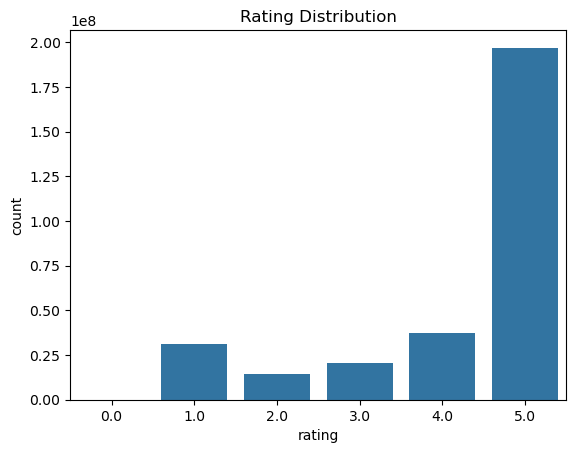

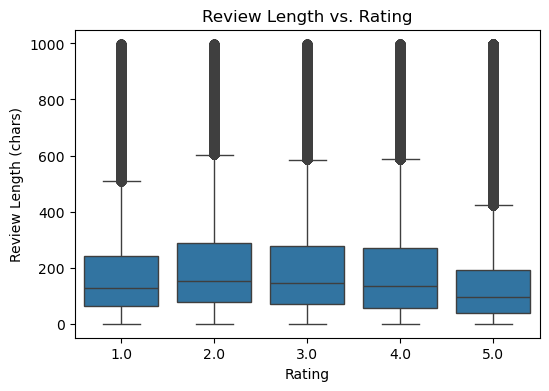

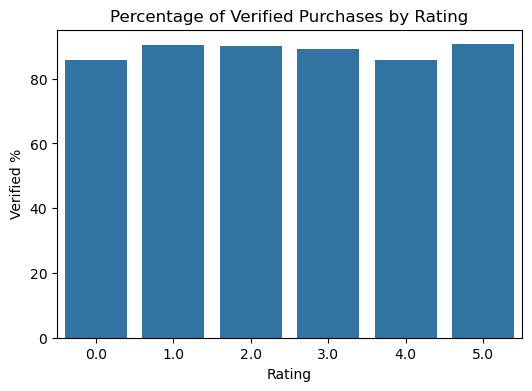

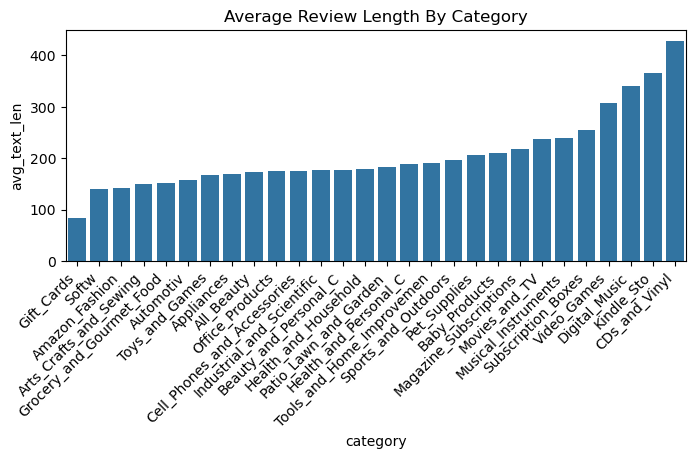

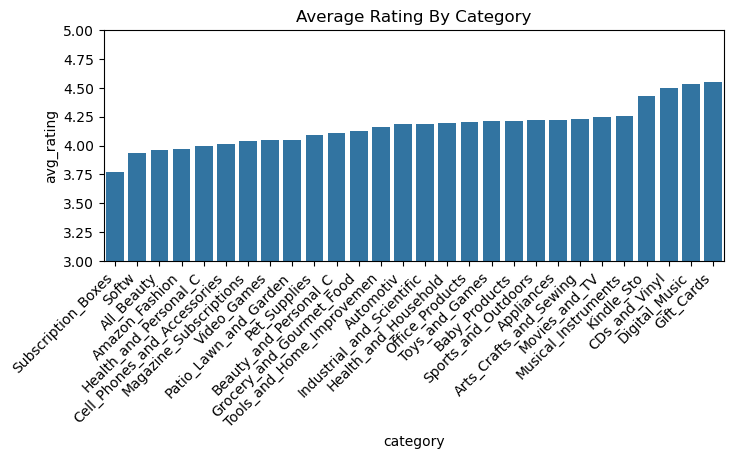

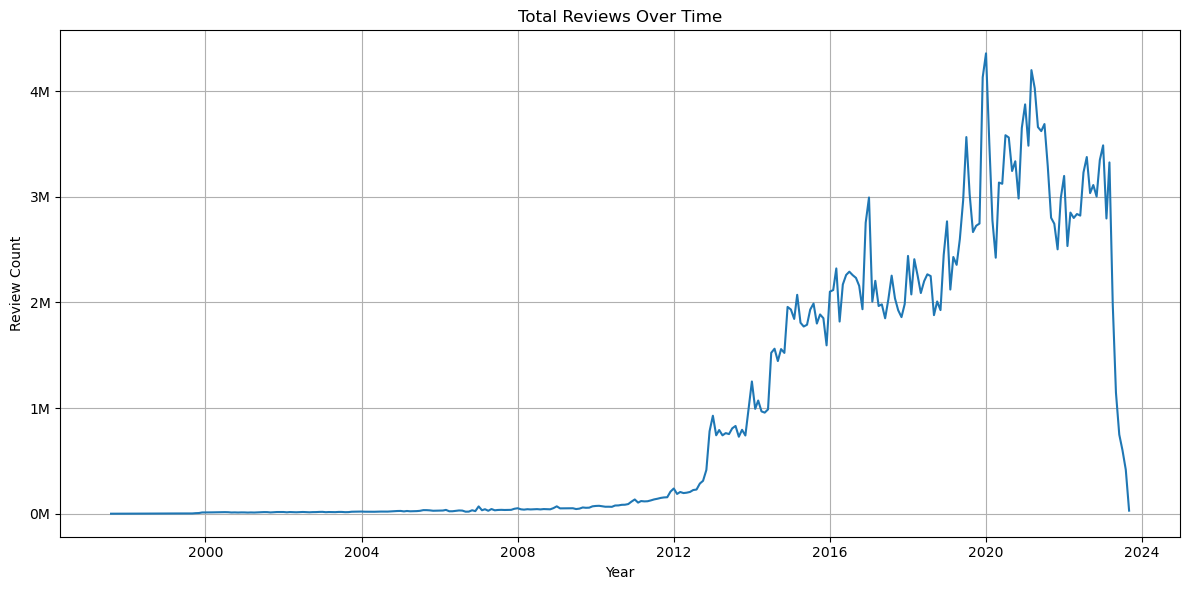

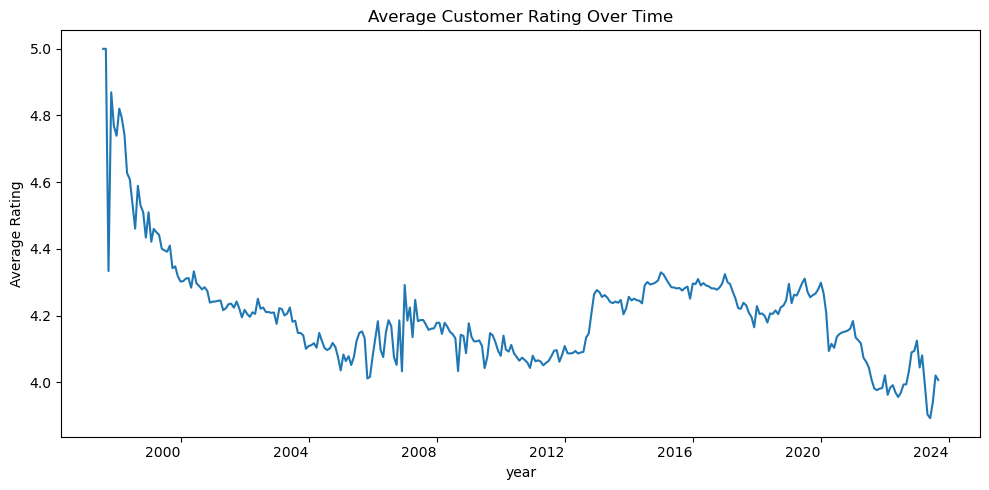

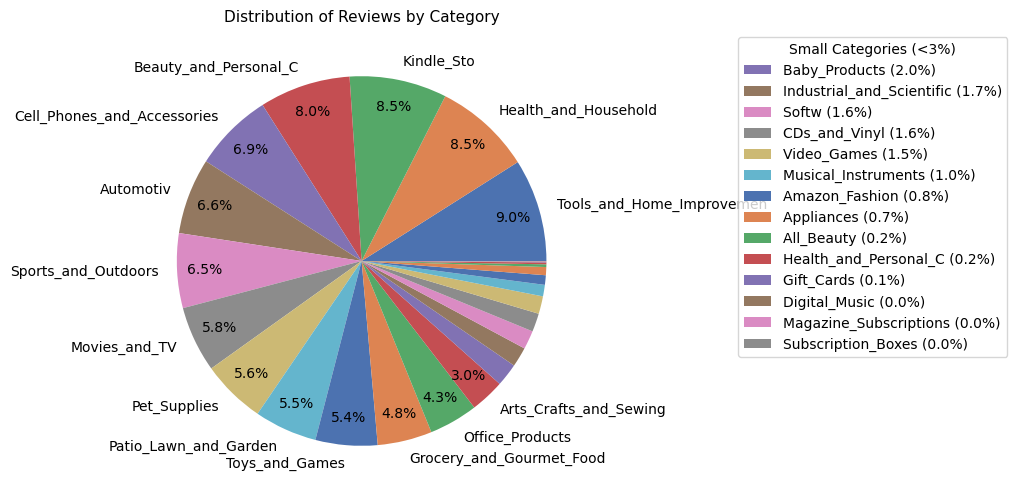

In [5]:
# 4.1 Ratings histogram
pdf = reviews.groupBy("rating") \
    .count() \
    .orderBy("rating") \
    .toPandas()
sns.barplot(x="rating", y="count", data=pdf)
plt.title("Rating Distribution")
plt.show()

# 4.2 Box Plot: Review length vs. Rating
scatter_pdf = reviews.select("text_len","rating") \
      .dropna() \
      .sample(False, 0.01, seed=1) \
      .filter(reviews.text_len < 1000) \
      .toPandas()
plt.figure(figsize=(6,4))
sns.boxplot(x='rating', y='text_len', data=scatter_pdf)
plt.xlabel("Rating")
plt.ylabel("Review Length (chars)")
plt.title("Review Length vs. Rating")
plt.show()

# 4.3 Verified vs. Unverified Purchase Ratings
    # Step 1: Count total reviews per rating
total_counts = reviews.groupBy("rating").count().withColumnRenamed("count", "total")
    # Step 2: Count verified reviews per rating
verified_counts = reviews.filter(F.col("verified_purchase") == "Y") \
                         .groupBy("rating") \
                         .count() \
                         .withColumnRenamed("count", "verified")
    # Step 3: Join and compute percentage
percent_df = verified_counts.join(total_counts, on="rating") \
                            .withColumn("percent_verified", (F.col("verified") / F.col("total")) * 100)
    # Convert to Pandas and plot
plot_df = percent_df.select("rating", "percent_verified").toPandas()
    # Plot
plt.figure(figsize=(6,4))
sns.barplot(x="rating", y="percent_verified", data=plot_df)
plt.title("Percentage of Verified Purchases by Rating")
plt.ylabel("Verified %")
plt.xlabel("Rating")
plt.show()

# 4.4 Average Review Length by Category
avg_txtlen_pd = reviews.groupBy("category") \
    .agg({"text_len": "avg"}) \
    .withColumnRenamed("avg(text_len)", "avg_text_len") \
    .orderBy("avg_text_len", ascending = True) \
    .toPandas()

plt.figure(figsize=(8, 3))
sns.barplot(x="category", y="avg_text_len", data=avg_txtlen_pd)
plt.xticks(rotation=45, ha="right")
plt.title("Average Review Length By Category")
plt.show()

# 4.5 Average Rating by Category
avg_rating_pd = reviews.groupBy("category") \
    .agg({"rating": "avg"}) \
    .withColumnRenamed("avg(rating)", "avg_rating") \
    .orderBy("avg_rating", ascending = True) \
    .toPandas()
plt.figure(figsize=(8, 3))
sns.barplot(x="category", y="avg_rating", data=avg_rating_pd)
plt.ylim(3, 5)
plt.xticks(rotation=45, ha="right")
plt.title("Average Rating By Category")
plt.show()

# 4.6 Total Reviews over time
monthly = reviews \
    .withColumn("month", date_trunc("month", from_unixtime(col("timestamp") / 1000))) \
    .groupBy("month") \
    .count() \
    .orderBy("month")
monthly_pd = monthly.toPandas().sort_values("month")
    #figure and axis(chart) object
fig, ax = plt.subplots(figsize=(12, 6))
    # Plot line
ax.plot(monthly_pd['month'], monthly_pd['count'])
    # Set title and labels
ax.set_title("Total Reviews Over Time")
ax.set_xlabel("Year")
ax.set_ylabel("Review Count")
    # Format Y-axis in millions
    # Take each tick mark and multiply by 1e-6 then format as whole number (0 decimals)
    #FuncFormatter takes two arguments -- value and tick position
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x * 1e-6:.0f}M')
)
    # Add grid and layout
ax.grid(True)
plt.tight_layout()
plt.show()

# 4.7 Average Customer Rating over time
review_ts = reviews.withColumn(
    "ts",
    from_unixtime(col("timestamp")/1000).cast("timestamp")
)
monthly_avg = (
    review_ts
      .withColumn("month", date_trunc("month", col("ts")))
      .groupBy("month")
      .agg(avg("rating").alias("avg_rating"))
      .orderBy("month")
)
pdf = monthly_avg.toPandas()
pdf["month"] = pd.to_datetime(pdf["month"])
    # Plot
plt.figure(figsize=(10, 5))
plt.plot(pdf["month"], pdf["avg_rating"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(ha="right")
plt.xlabel("year")
plt.ylabel("Average Rating")
plt.title("Average Customer Rating Over Time")
plt.tight_layout()
plt.show()

# 4.8 Distribution of Reviews by Category
    # Create dataframe with counts for each category
category_counts_pd = reviews.groupBy("category") \
    .count() \
    .orderBy("count", ascending=False) \
    .toPandas()

    # Calculate total count (for next step)
total_count = category_counts_pd["count"].sum()

    # Determine which categories are below 3%
category_counts_pd["percentage"] = (category_counts_pd["count"] / total_count) * 100
small_categories = category_counts_pd[category_counts_pd["percentage"] < 2.9]
large_categories = category_counts_pd[category_counts_pd["percentage"] >= 2.9]

    # Define custom percentage formatting function
def autopct_format(pct):
    return f'{pct:.1f}%' if pct >= 2.9 else ''  # Hide small percentages

    # Generate colors for all categories
colors = sns.color_palette("deep", len(category_counts_pd))  # Ensure enough colors

    # Plot the pie chart
plt.figure(figsize=(6,6))
wedges, texts, autotexts = plt.pie(
    category_counts_pd["count"], 
    labels=[label if pct >= 2.9 else "" for label, pct in zip(category_counts_pd["category"], category_counts_pd["percentage"])],  # Hide small labels
    autopct=autopct_format,  
    startangle=0, 
    pctdistance=0.85, 
    labeldistance=1.1, 
    colors=colors  # Apply colors correctly
)

    # Extract colors for small categories
small_category_colors = [wedge.get_facecolor() for i, wedge in enumerate(wedges) if category_counts_pd["percentage"].iloc[i] < 2.9]

# Add a legend for small categories with correct colors
if not small_categories.empty:
    legend_labels = [f"{row['category']} ({row['percentage']:.1f}%)" for _, row in small_categories.iterrows()]
    plt.legend(wedges[-len(small_categories):], legend_labels, loc="best", fontsize=10, bbox_to_anchor=(1.3, 1), title="Small Categories (<3%)")

plt.title("Distribution of Reviews by Category", fontsize=11)
plt.show()

Linear Regression with the entire dataset, but undersampling rating=5 as it is the dominant class. Also creating custom bins instead of default rounding to help improve accuracy. 

In [5]:
import time
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, StringIndexer, OneHotEncoder, HashingTF, IDF, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import round


# Timer start
total_start = time.time()

# Step 1: Filter and feature engineering
print("Filtering and preparing features...")
t1 = time.time()

reviews_clean = reviews.filter(col("rating").isNotNull() & col("text").isNotNull())

fraction_to_keep = 0.4
majority_df = df.filter(col("rating") == 5)
minority_df = df.filter(col("rating") != 5)
majority_sampled = majority_df.sample(withReplacement=False, fraction=fraction_to_keep, seed=42)
reviews_clean = minority_df.union(majority_sampled).cache()

#reviews_clean = reviews_undersampled.sample(withReplacement=False, fraction=0.01, seed=42).cache()

reviews_fe = reviews_clean.selectExpr(
    "rating", "title", "text", "verified_purchase", "helpful_vote", "timestamp", "category",
    "length(text) as text_length",
    "cast(verified_purchase as double) as verified_numeric"
)

print(f"Step 1 complete in {time.time() - t1:.2f} seconds")

print("Defining pipeline stages...")
t2 = time.time()

text_tokenizer = RegexTokenizer(inputCol="text", outputCol="text_tokens")
text_remover = StopWordsRemover(inputCol="text_tokens", outputCol="text_filtered")
text_hashingTF = HashingTF(inputCol="text_filtered", outputCol="text_rawFeatures", numFeatures=10000)
text_idf = IDF(inputCol="text_rawFeatures", outputCol="textFeatures")

title_tokenizer = RegexTokenizer(inputCol="title", outputCol="title_tokens")
title_remover = StopWordsRemover(inputCol="title_tokens", outputCol="title_filtered")
title_hashingTF = HashingTF(inputCol="title_filtered", outputCol="title_rawFeatures", numFeatures=5000)
title_idf = IDF(inputCol="title_rawFeatures", outputCol="titleFeatures")

category_indexer = StringIndexer(inputCol="category", outputCol="category_index", handleInvalid="keep")
category_encoder = OneHotEncoder(inputCol="category_index", outputCol="category_encoded")

assembler = VectorAssembler(
    inputCols=["textFeatures", "titleFeatures", "text_length", "verified_numeric", "helpful_vote", "timestamp", "category_encoded"],
    outputCol="features"
)


lr = LinearRegression(
    featuresCol="features",
    labelCol="rating",
    maxIter=100,
    regParam=0.005,      
    elasticNetParam=0.0   
)


pipeline = Pipeline(stages=[
    text_tokenizer, text_remover, text_hashingTF, text_idf,
    title_tokenizer, title_remover, title_hashingTF, title_idf,
    category_indexer, category_encoder,
    assembler,
    lr
])
print(f"Step 2 complete in {time.time() - t2:.2f} seconds")

# Step 3: Train-test split
print("Splitting data...")
t3 = time.time()
train_df, test_df = reviews_fe.randomSplit([0.8, 0.2], seed=42)
train_df = train_df.repartition(100)
test_df = test_df.repartition(50)
print(f"Step 3 complete in {time.time() - t3:.2f} seconds")

# Step 4: Train model
print("Training model...")
t4 = time.time()
model = pipeline.fit(train_df)
print(f"Model training complete in {time.time() - t4:.2f} seconds")

# Step 5: Make predictions
print("Making predictions...")
t5 = time.time()
predictions = model.transform(test_df)
print(f"Predictions complete in {time.time() - t5:.2f} seconds")

# Step 6: Evaluate accuracy
print("Evaluating accuracy...")
t6 = time.time()

rounded_preds = predictions.withColumn("rounded_prediction", 
    when(col("prediction") < 2.5, 1.0)
   .when(col("prediction") < 2.85, 2.0)
   .when(col("prediction") < 3.3, 3.0)
   .when(col("prediction") < 4.05, 4.0)
   .otherwise(5.0)
)


evaluator = MulticlassClassificationEvaluator(
    labelCol="rating",
    predictionCol="rounded_prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(rounded_preds)

print(f"Evaluation complete in {time.time() - t6:.2f} seconds")

# Final output
print(f"Test accuracy: {accuracy:.4f}")
print(f"Total time elapsed: {time.time() - total_start:.2f} seconds")

Filtering and preparing features...
Step 1 complete in 0.40 seconds
Defining pipeline stages...
Step 2 complete in 0.76 seconds
Splitting data...
Step 3 complete in 0.01 seconds
Training model...
Model training complete in 112.78 seconds
Making predictions...
Predictions complete in 0.18 seconds
Evaluating accuracy...
Evaluation complete in 5.15 seconds
Test accuracy: 0.5233
Total time elapsed: 119.28 seconds


Random Forest with review text and other features (1% of data size):

In [4]:
import time
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, HashingTF, IDF,
    StringIndexer, VectorAssembler
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, length

# Spark config tuning
sc.conf.set("spark.sql.shuffle.partitions", "64")  # Reduced partitions for better performance

# Timer start
total_start = time.time()

# Step 1: Filter and feature engineering
print("Filtering and preparing features...")
t1 = time.time()

reviews_clean = reviews.filter(col("rating").isNotNull() & col("text").isNotNull()).sample(False, 0.01, seed=42).repartition(100)
#reviews_clean = reviews_clean.sample(False, 0.1, seed=42).repartition(100)

# Feature engineering (removed raw timestamp)
reviews_fe = reviews_clean.selectExpr(
    "rating", "text", "verified_purchase", "helpful_vote", "category",
    "length(text) as text_length",
    "cast(verified_purchase as double) as verified_numeric"
)

print(f"Step 1 complete in {time.time() - t1:.2f} seconds")

# Step 2: Define pipeline stages
print("Defining pipeline stages...")
t2 = time.time()

# Define transformation stages
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="textFeatures")
category_indexer = StringIndexer(inputCol="category", outputCol="category_index", handleInvalid="keep")

assembler = VectorAssembler(
    inputCols=["textFeatures", "text_length", "verified_numeric", "helpful_vote", "category_index"],
    outputCol="features"
)

rf = RandomForestClassifier(
    labelCol="rating", 
    featuresCol="features",
    numTrees=10,
    maxDepth=5,
    maxBins=64,
    seed=42
)

pipeline = Pipeline(stages=[
    tokenizer, remover, hashingTF, idf,
    category_indexer,
    assembler,
    rf
])
print(f"Step 2 complete in {time.time() - t2:.2f} seconds")

# Step 3: Train-test split
print("Splitting data...")
t3 = time.time()
train_df, test_df = reviews_fe.randomSplit([0.8, 0.2], seed=42)
print(f"Step 3 complete in {time.time() - t3:.2f} seconds")

# Step 4: Train model
print("Training model...")
t4 = time.time()
model = pipeline.fit(train_df)
print(f"Model training complete in {time.time() - t4:.2f} seconds")

# Step 5: Make predictions
print("Making predictions...")
t5 = time.time()
predictions = model.transform(test_df)
print(f"Predictions complete in {time.time() - t5:.2f} seconds")

# Step 6: Evaluate accuracy
print("Evaluating accuracy...")
t6 = time.time()
evaluator = MulticlassClassificationEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Evaluation complete in {time.time() - t6:.2f} seconds")

# Final output
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Total time elapsed: {time.time() - total_start:.2f} seconds")


Filtering and preparing features...
Step 1 complete in 0.07 seconds
Defining pipeline stages...
Step 2 complete in 0.68 seconds
Splitting data...
Step 3 complete in 0.02 seconds
Training model...
Model training complete in 235.37 seconds
Making predictions...
Predictions complete in 0.13 seconds
Evaluating accuracy...
Evaluation complete in 30.25 seconds
Test Accuracy: 0.6564
Total time elapsed: 266.54 seconds


Random Forest with review text and other features (5% of data size):

In [5]:
import time
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, HashingTF, IDF,
    StringIndexer, VectorAssembler
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, length

# Spark config tuning
sc.conf.set("spark.sql.shuffle.partitions", "64")  # Reduced partitions for better performance

# Timer start
total_start = time.time()

# Step 1: Filter and feature engineering
print("Filtering and preparing features...")
t1 = time.time()

reviews_clean = reviews.filter(col("rating").isNotNull() & col("text").isNotNull()).sample(False, 0.05, seed=42).repartition(100)
#reviews_clean = reviews_clean.sample(False, 0.1, seed=42).repartition(100)

# Feature engineering (removed raw timestamp)
reviews_fe = reviews_clean.selectExpr(
    "rating", "text", "verified_purchase", "helpful_vote", "category",
    "length(text) as text_length",
    "cast(verified_purchase as double) as verified_numeric"
)

print(f"Step 1 complete in {time.time() - t1:.2f} seconds")

# Step 2: Define pipeline stages
print("Defining pipeline stages...")
t2 = time.time()

# Define transformation stages
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="textFeatures")
category_indexer = StringIndexer(inputCol="category", outputCol="category_index", handleInvalid="keep")

assembler = VectorAssembler(
    inputCols=["textFeatures", "text_length", "verified_numeric", "helpful_vote", "category_index"],
    outputCol="features"
)

rf = RandomForestClassifier(
    labelCol="rating", 
    featuresCol="features",
    numTrees=10,
    maxDepth=5,
    maxBins=64,
    seed=42
)

pipeline = Pipeline(stages=[
    tokenizer, remover, hashingTF, idf,
    category_indexer,
    assembler,
    rf
])
print(f"Step 2 complete in {time.time() - t2:.2f} seconds")

# Step 3: Train-test split
print("Splitting data...")
t3 = time.time()
train_df, test_df = reviews_fe.randomSplit([0.8, 0.2], seed=42)
print(f"Step 3 complete in {time.time() - t3:.2f} seconds")

# Step 4: Train model
print("Training model...")
t4 = time.time()
model = pipeline.fit(train_df)
print(f"Model training complete in {time.time() - t4:.2f} seconds")

# Step 5: Make predictions
print("Making predictions...")
t5 = time.time()
predictions = model.transform(test_df)
print(f"Predictions complete in {time.time() - t5:.2f} seconds")

# Step 6: Evaluate accuracy
print("Evaluating accuracy...")
t6 = time.time()
evaluator = MulticlassClassificationEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Evaluation complete in {time.time() - t6:.2f} seconds")

# Final output
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Total time elapsed: {time.time() - total_start:.2f} seconds")


Filtering and preparing features...
Step 1 complete in 0.02 seconds
Defining pipeline stages...
Step 2 complete in 0.02 seconds
Splitting data...
Step 3 complete in 0.01 seconds
Training model...
Model training complete in 533.30 seconds
Making predictions...
Predictions complete in 0.11 seconds
Evaluating accuracy...
Evaluation complete in 50.50 seconds
Test Accuracy: 0.6558
Total time elapsed: 583.98 seconds


Random Forest with review text and other features (10% of data size):

In [4]:
import time
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, HashingTF, IDF,
    StringIndexer, VectorAssembler
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, length

# Spark config tuning
sc.conf.set("spark.sql.shuffle.partitions", "64")  # Reduced partitions for better performance

# Timer start
total_start = time.time()

# Step 1: Filter and feature engineering
print("Filtering and preparing features...")
t1 = time.time()

reviews_clean = reviews.filter(col("rating").isNotNull() & col("text").isNotNull()).sample(False, 0.1, seed=42).repartition(100)
#reviews_clean = reviews_clean.sample(False, 0.1, seed=42).repartition(100)

# Feature engineering (removed raw timestamp)
reviews_fe = reviews_clean.selectExpr(
    "rating", "text", "verified_purchase", "helpful_vote", "category",
    "length(text) as text_length",
    "cast(verified_purchase as double) as verified_numeric"
)

print(f"Step 1 complete in {time.time() - t1:.2f} seconds")

# Step 2: Define pipeline stages
print("Defining pipeline stages...")
t2 = time.time()

# Define transformation stages
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="textFeatures")
category_indexer = StringIndexer(inputCol="category", outputCol="category_index", handleInvalid="keep")

assembler = VectorAssembler(
    inputCols=["textFeatures", "text_length", "verified_numeric", "helpful_vote", "category_index"],
    outputCol="features"
)

rf = RandomForestClassifier(
    labelCol="rating", 
    featuresCol="features",
    numTrees=10,
    maxDepth=5,
    maxBins=64,
    seed=42
)

pipeline = Pipeline(stages=[
    tokenizer, remover, hashingTF, idf,
    category_indexer,
    assembler,
    rf
])
print(f"Step 2 complete in {time.time() - t2:.2f} seconds")

# Step 3: Train-test split
print("Splitting data...")
t3 = time.time()
train_df, test_df = reviews_fe.randomSplit([0.8, 0.2], seed=42)
print(f"Step 3 complete in {time.time() - t3:.2f} seconds")

# Step 4: Train model
print("Training model...")
t4 = time.time()
model = pipeline.fit(train_df)
print(f"Model training complete in {time.time() - t4:.2f} seconds")

# Step 5: Make predictions
print("Making predictions...")
t5 = time.time()
predictions = model.transform(test_df)
print(f"Predictions complete in {time.time() - t5:.2f} seconds")

# Step 6: Evaluate accuracy
print("Evaluating accuracy...")
t6 = time.time()
evaluator = MulticlassClassificationEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Evaluation complete in {time.time() - t6:.2f} seconds")

# Final output
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Total time elapsed: {time.time() - total_start:.2f} seconds")


Filtering and preparing features...
Step 1 complete in 0.08 seconds
Defining pipeline stages...
Step 2 complete in 0.74 seconds
Splitting data...
Step 3 complete in 0.02 seconds
Training model...
Model training complete in 1080.36 seconds
Making predictions...
Predictions complete in 0.10 seconds
Evaluating accuracy...
Evaluation complete in 69.36 seconds
Test Accuracy: 0.6559
Total time elapsed: 1150.65 seconds


In [5]:
# Step 5: Make predictions
print("Making predictions...")
t5 = time.time()
test_predictions = model.transform(test_df)
train_predictions = model.transform(train_df)
print(f"Predictions complete in {time.time() - t5:.2f} seconds")

# Step 6: Evaluate accuracy
print("Evaluating accuracy...")
t6 = time.time()
evaluator = MulticlassClassificationEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="accuracy"
)
test_accuracy = evaluator.evaluate(test_predictions)
train_accuracy = evaluator.evaluate(train_predictions)
print(f"Evaluation complete in {time.time() - t6:.2f} seconds")

# Output results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Making predictions...
Predictions complete in 0.18 seconds
Evaluating accuracy...
Evaluation complete in 237.67 seconds
Train Accuracy: 0.6561
Test Accuracy: 0.6559


**Answering Questions and Conclusion:**

Our Random Forest model fits well within the ideal zone of the fitting graph. The training and test accuracies are nearly identical (65.6%), indicating that the model is neither underfitting nor overfitting. It generalizes well to unseen data and falls near the optimal point on the bias-variance curve.

We began with linear regression by rounding star ratings to approximate categorical labels, but the results were underwhelming. We also experimented with logistic regression and XGBoost, which produced similarly subpar performance. Given that our target variable is inherently categorical, we concluded that regression-based approaches were not well suited for this task. We then shifted to a Random Forest classifier, which delivered significantly better results and validated our decision to move toward tree-based models. This progression reflects our iterative approach to model selection in response to the question, "What are the next models you are thinking of and why?"

To also address the question, "What is the conclusion of your first model? What can be done to possibly improve it?": Our first model, linear regression with rounded predictions, performed poorly because it was not designed for categorical outcomes. To improve upon that initial approach, we would need to move away from regression entirely and adopt classification methods that align better with the nature of the data. This is precisely what led us to explore Random Forests and other classifiers. At this point, we’re focused on tuning the Random Forest model further — adjusting parameters such as the number of trees, maximum depth, and feature subsets — to optimize performance and reduce variance without overfitting.

(Optional to include below):

We attempted 20% below, but it runs into memory error due to size of data set. The increase in data set size from 3 million, to 15 million,  to 30 million did not improve test error significantly if at all, so increasing the data set size for training beyond this point seems unnecessary.

In [4]:
import time
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, HashingTF, IDF,
    StringIndexer, VectorAssembler
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, length

# Spark config tuning
sc.conf.set("spark.sql.shuffle.partitions", "64")  # Reduced partitions for better performance

# Timer start
total_start = time.time()

# Step 1: Filter and feature engineering
print("Filtering and preparing features...")
t1 = time.time()

reviews_clean = reviews.filter(col("rating").isNotNull() & col("text").isNotNull()).sample(False, 0.15, seed=42).repartition(100)
#reviews_clean = reviews_clean.sample(False, 0.1, seed=42).repartition(100)

# Feature engineering (removed raw timestamp)
reviews_fe = reviews_clean.selectExpr(
    "rating", "text", "verified_purchase", "helpful_vote", "category",
    "length(text) as text_length",
    "cast(verified_purchase as double) as verified_numeric"
)

print(f"Step 1 complete in {time.time() - t1:.2f} seconds")

# Step 2: Define pipeline stages
print("Defining pipeline stages...")
t2 = time.time()

# Define transformation stages
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="textFeatures")
category_indexer = StringIndexer(inputCol="category", outputCol="category_index", handleInvalid="keep")

assembler = VectorAssembler(
    inputCols=["textFeatures", "text_length", "verified_numeric", "helpful_vote", "category_index"],
    outputCol="features"
)

rf = RandomForestClassifier(
    labelCol="rating", 
    featuresCol="features",
    numTrees=10,
    maxDepth=5,
    maxBins=64,
    seed=42
)

pipeline = Pipeline(stages=[
    tokenizer, remover, hashingTF, idf,
    category_indexer,
    assembler,
    rf
])
print(f"Step 2 complete in {time.time() - t2:.2f} seconds")

# Step 3: Train-test split
print("Splitting data...")
t3 = time.time()
train_df, test_df = reviews_fe.randomSplit([0.8, 0.2], seed=42)
print(f"Step 3 complete in {time.time() - t3:.2f} seconds")

# Step 4: Train model
print("Training model...")
t4 = time.time()
model = pipeline.fit(train_df)
print(f"Model training complete in {time.time() - t4:.2f} seconds")

# Step 5: Make predictions
print("Making predictions...")
t5 = time.time()
predictions = model.transform(test_df)
print(f"Predictions complete in {time.time() - t5:.2f} seconds")

# Step 6: Evaluate accuracy
print("Evaluating accuracy...")
t6 = time.time()
evaluator = MulticlassClassificationEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Evaluation complete in {time.time() - t6:.2f} seconds")

# Final output
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Total time elapsed: {time.time() - total_start:.2f} seconds")


Filtering and preparing features...
Step 1 complete in 0.07 seconds
Defining pipeline stages...
Step 2 complete in 0.66 seconds
Splitting data...
Step 3 complete in 0.02 seconds
Training model...


Py4JJavaError: An error occurred while calling o244.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 373 in stage 68.0 failed 1 times, most recent failure: Lost task 373.0 in stage 68.0 (TID 4459) (exp-4-31.expanse.sdsc.edu executor driver): java.io.IOException: No space left on device
	at java.base/java.io.FileOutputStream.writeBytes(Native Method)
	at java.base/java.io.FileOutputStream.write(FileOutputStream.java:349)
	at org.apache.spark.storage.TimeTrackingOutputStream.write(TimeTrackingOutputStream.java:59)
	at org.apache.spark.io.MutableCheckedOutputStream.write(MutableCheckedOutputStream.scala:43)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:225)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:178)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:112)
	at org.apache.spark.sql.catalyst.expressions.UnsafeRow.writeToStream(UnsafeRow.java:527)
	at org.apache.spark.sql.execution.UnsafeRowSerializerInstance$$anon$1.writeValue(UnsafeRowSerializer.scala:69)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:312)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.io.IOException: No space left on device
	at java.base/java.io.FileOutputStream.writeBytes(Native Method)
	at java.base/java.io.FileOutputStream.write(FileOutputStream.java:349)
	at org.apache.spark.storage.TimeTrackingOutputStream.write(TimeTrackingOutputStream.java:59)
	at org.apache.spark.io.MutableCheckedOutputStream.write(MutableCheckedOutputStream.scala:43)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:225)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:178)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:112)
	at org.apache.spark.sql.catalyst.expressions.UnsafeRow.writeToStream(UnsafeRow.java:527)
	at org.apache.spark.sql.execution.UnsafeRowSerializerInstance$$anon$1.writeValue(UnsafeRowSerializer.scala:69)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:312)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)


Link to download data: https://amazon-reviews-2023.github.io/index.html